# Deep dive

In [1]:
from bhad import (model, utils)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [52]:
seed = None  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 2*10**5                     # sample size

# Specify first and second moments for each component  
bvt = utils.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(200000, 30)


In [53]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.0106

In [54]:
yy = dataset['var0'].values

Plot Bart Simpson density:

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000)

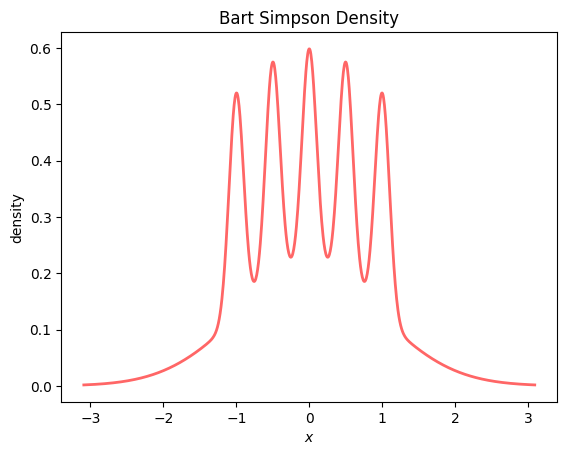

In [56]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, utils.bart_simpson_density(x, m = 4), 'r-', lw=2, alpha=0.6, label='norm pdf')
ax.set_xlabel(r'$x$')
ax.set_ylabel('density')
ax.set_title(r'Bart Simpson Density')
#fig.savefig('bart_simpson_density.png')   # save the figure to file
plt.show();
#plt.close(fig);    # close the figure window

In [57]:
opt_M = 50

grid = np.linspace(-4,4,100)

# Draw a sample via Accept/Reject sampling:
#-------------------------------------------
y = utils.rbartsim(MCsim = 10**5, seed = None, verbose = True)


Acceptance rate: 0.46503



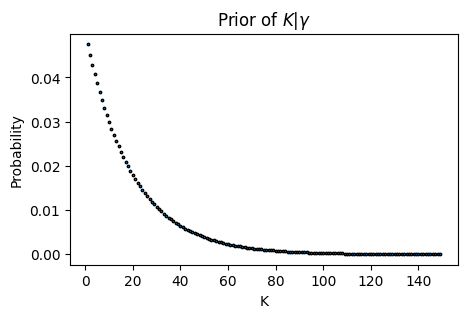

In [58]:
max_M = 150
gamma = 0.95
gp = [utils.geometric_prior(m, gamma = gamma, max_M = max_M) for m in range(1,max_M, 1)] 

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.scatter(range(1,max_M, 1), gp, s=3, edgecolors='black')
ax.set_xlabel(r'K')
ax.set_ylabel('Probability')     # unnormalized
ax.set_title(r'Prior of $K|\gamma$');

In [59]:
from scipy.integrate import simpson

gamma_grid = np.linspace(1e-4,1-1e-4, 30)

prior_max_M = 100

log_marg_prior_nbins = {}
for m in range(1, prior_max_M, 1):
    
    prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

    area = simpson(utils.exp_normalize(prior), gamma_grid)
    #area = simpson(prior, gamma_grid)
    
    log_marg_prior_nbins[m] = np.log(1e-10 + area)

log_marg_prior_nbins[58]

-3.4015676040742115

In [60]:
log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}

# Compute K_MAP for each feature:
#---------------------------------
nopt_M = max(log_marg_post, key=log_marg_post.get)
opt_M

50

In [61]:
#log_marg_prior_nbins = {m : np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid]), gamma_grid)) for m in range(1, prior_max_M, 1)}
#log_marg_prior_nbins

Plot posterior of number of bins:

In [62]:
post = utils.exp_normalize(np.array(list(log_marg_post.values())))
lpost = list(log_marg_post.values())
xx = np.array(list(log_marg_post.keys()))

In [63]:
#lpr = {m : log_marg_prior_nbins[m] + log_marglike_nbins(M = m, y = v) for m in range(1,self.prior_max_M, 1)}

In [64]:
m = 22

log_marg_prior_nbins = np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = 100, log = False) for g in gamma_grid]), gamma_grid))
log_marg_prior_nbins

-6.25420915398745

In [65]:
#-----------------------------
# HPD of number of bins:
#-------------------------------
sig_level = 0.05
upper = np.sum(np.cumsum(post) <= (1-(sig_level/2))) 
lower = np.sum(np.cumsum(post) <= sig_level/2) 
median = np.sum(np.cumsum(post) <= 0.5) 
opt_M = np.argmax(post) 
print(opt_M)
print((lower, median, upper))

94
(94, 94, 94)


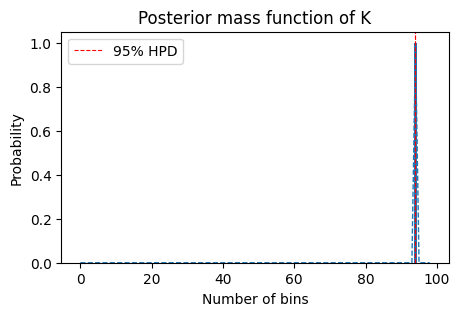

In [66]:
fig = plt.figure(figsize=(5,3))
ax = plt.axes()

s = xx - 1
#s = xx[(xx > 20) & (xx < 80)] 

#ax.plot(xx, post)
ax.plot(s, post[s], '--', linewidth=1)
#ax.bar(s, post)
ax.bar(s, post[s])
#ax.scatter(s, pr)
ax.axvline(x = lower, color = 'red',linestyle = '--', linewidth=0.8, label = f'{int((1-sig_level)*100)}% HPD')
ax.axvline(x = upper, color = 'red',linestyle = '--', linewidth=0.8)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Probability')
ax.legend(loc="upper left")
ax.set_title('Posterior mass function of K')
#fig.savefig('post_k.png')   # save the figure to file
plt.show();
#plt.close(fig)    # close the figure window

In [67]:
from scipy.stats import iqr

opt_sturges = int(1 + 3.322*np.log(len(y)))

print(f'\nMAP number of bins: {opt_M}')
print(f'Sturges rule: {opt_sturges}')

# Freedman-Diaconis rule:
bw = 2*iqr(y)*N**(-1/3)
FD = (max(y) - min(y))/bw
opt_fd = int(FD)
print(f'Freedman-Diaconis rule: {opt_fd}')


MAP number of bins: 94
Sturges rule: 36
Freedman-Diaconis rule: 194


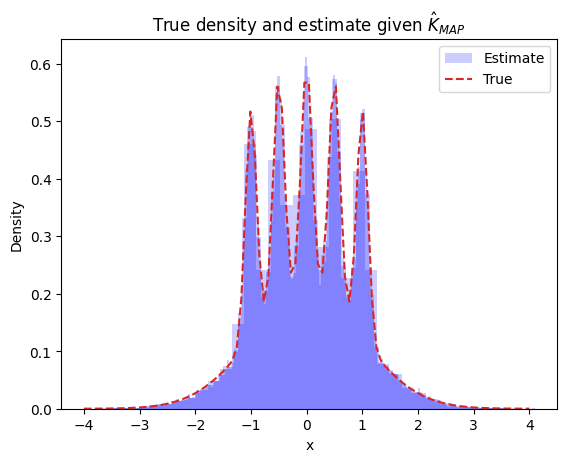

In [68]:
y_true = utils.bart_simpson_density(grid)

fig = plt.figure()

# create the histogram
counts1, bins1, patches1 = plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
counts2, bins2, patches2 = plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2); main = 'Freedman-Diaconis'
counts3, bins3, patches3 = plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2); main = 'Sturges'

plt.plot(grid, y_true, linestyle='dashed', label='True')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title(r'True density and estimate given $\hat{K}_{MAP}$ ')    #  with Bayes estimate number of bins
#fig.savefig(f'est_Bart_{main}.png')   # save the figure to file

plt.show();
#plt.close(fig)    # close the figure window

In [69]:

#bucket_index = np.max(np.where(bins <= -3.31807179))

ord1, ord2, ord3 = [], [], []
for x in grid:
    
    if np.any(bins1 <= x):
        bucket_index1 = np.max(np.where(bins1 <= x))
        ord1.append(counts1[bucket_index1-1])
    else:
        ord1.append(counts1[0])

    if np.any(bins2 <= x):
        bucket_index2 = np.max(np.where(bins2 <= x))
        ord2.append(counts2[bucket_index2-1])
    else:
        ord2.append(counts2[0])

    if np.any(bins3 <= x):
        bucket_index3 = np.max(np.where(bins3 <= x))
        ord3.append(counts3[bucket_index3-1])
    else:
        ord3.append(counts3[0])


MSEs:

In [70]:
import pandas as pd

df = pd.DataFrame()
df['x'] = grid
#df['ytrue'] = y_true
df['mse1'] = (y_true-ord1)**2    # Bayes
df['mse2'] = (y_true-ord2)**2    # Freedman
df['mse3'] = (y_true-ord3)**2    # Sturges

np.mean(df.values, axis=0)[1:]

array([0.00575337, 0.00152385, 0.01471387])

In [139]:
counts, bin_edges = np.histogram(y, bins = range(20+1))
dict(zip(bin_edges, counts))

{0: 1779,
 1: 562,
 2: 41,
 3: 3,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0}